-------

# Apply Auto-Encoders to Restore Images

Watch the following 4 minute video on using an Auto-Encoder called DeepRemaster to restore old and grainy black and white video into higher quality, color video. 

It's a great video that sets up what we will be doing with our auto-encoder in this section. 

By the way here's the [**link to the white paper mentioned in this video**](https://arxiv.org/pdf/2009.08692.pdf) just in case you'd like to read through it. 

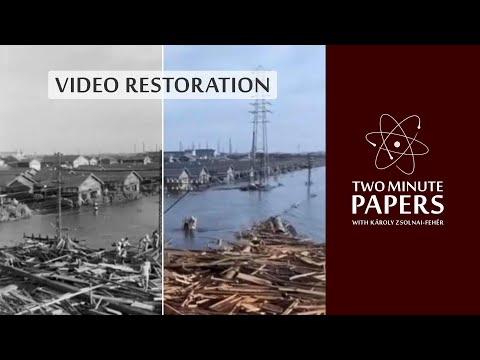

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('EjVzjxihGvU', width=1000, height=500)

As you saw in the video, the model architecture for DeepRemaster is a big complex beast of a model. And, since it is processing video data, you can image how much computational resources and time are required to properly train such a beastie. 

In this section, we will perform the same time of process but on a smaller and simpler scale - though the basic idea is the same. We will train an auto-encoder to restore damaged images. The beautiful and beneficial thing about performing the same basic restoration process but on a simpler problem is that we are able to understand the basic process without too many complications. Then, if this is something that you'd like to explore further, you can do so with the advantage of already having solved a similar and simpler version of the same problem. 

In [49]:
import os
import random
import numpy as np
from numpy.random import normal

import tensorflow as tf
from tensorflow import keras

# need these layers for 1st section
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model

from sklearn.utils import shuffle
from keras.datasets.mnist import load_data


# need these layers for 2nd section
from keras import layers
from keras.layers import Reshape, Conv2DTranspose, Flatten

import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1: Application of Auto-Encoders


# Restore Damaged Mnist Dataset

In this exercise, our tasks is to build a model that restores damaged images, namely damaged mnist digits. Because this is an exercise, we'll have to damage the images ourselves by adding randomly sampling a normal distribution. 

### Load and Normalize Image data

In [2]:
# load in mnist dataset 
(x_train, y_train), (x_test, y_test) = load_data()

11501568/11490434 [==============================] - 3s 0us/step


In [10]:
# normalize pixel values between 0 and 1 for both the train and test set 
# save results to `x_train_norm` and `x_test_norm`

# YOUR CODE HERE
max_pixel_val = x_train.max()

x_train_norm = x_train / max_pixel_val
x_test_norm = x_test / max_pixel_val

In [11]:
assert x_train_norm.max() == 1.0, "Did you normalized your training set?"
assert x_test_norm.max() == 1.0, "Did you normalized your test set?"

### Visualize Original and Damaged Images

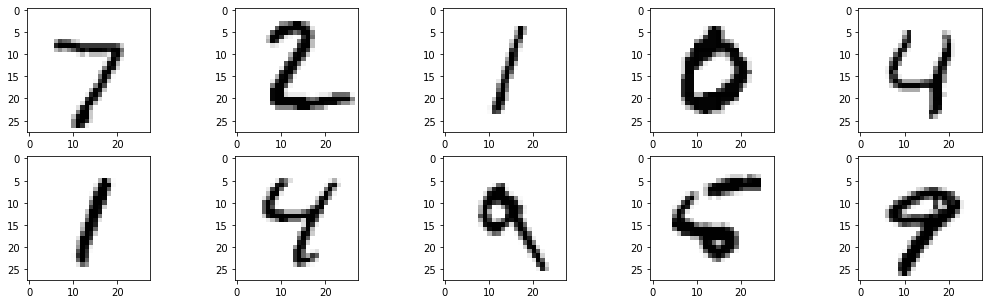

In [12]:
# here we can see the first 10 original images from the test set 
plt.figure(figsize=(18,5))
# helper function used to plot images 
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_norm[index], cmap=plt.cm.binary)
plt.show()

### Damage Our Images

We'll be damaging our images by adding noise to each pixel. We'll do this by sampling a normal distribution. 

In [14]:
# index the .shape attribute to get the height of our images - save result to `n_rows`
# index the .shape attribute to get the width of our images - save result to `n_cols`


# move n_rows and n_cols into a tuple - save results to `size`


# since our images are normalized we will sample normalize distribution with these parameters 
mean = 0.5
stddev = 0.3

# randomly sample from a normal distribution 

# creating the noisy train data by adding noise to x_train_norm - save result to `x_train_noisy`


# creating the noisy test data by adding noise to x_test_norm - save result to `x_test_noisy`



# YOUR CODE HERE
n_rows = x_train_norm.shape[1]
n_cols = x_train_norm.shape[2]

size = (n_rows, n_cols)

In [43]:
x_train_noisy = np.add(x_train_norm, np.random.normal(mean, stddev, size))

In [47]:
x_test_noisy = np.add(x_test_norm, np.random.normal(mean, stddev, size))   

In [46]:
x_train_noisy.shape

(60000, 28, 28)

You should be seeing highly grainy images of hand written digits below. By normalizing our images and adding noise sampled from a normal distribution centered around 0.5, we have created damaged images. Now our next task is to build an auto-encoder that learns how to restore the original images. 

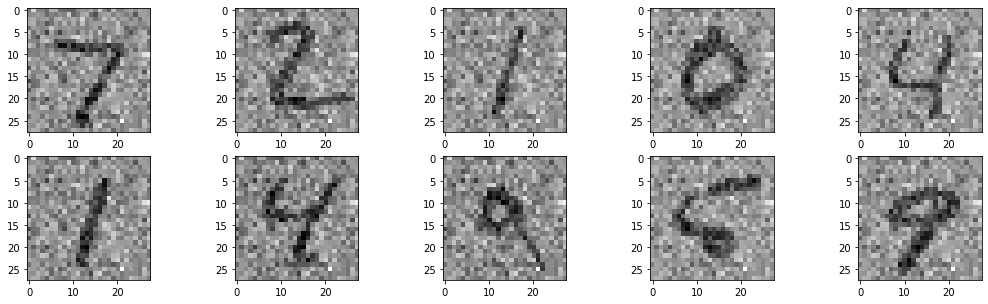

In [48]:
plt.figure(figsize=(18,5))

# helper function used to plot images 
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_noisy[index], cmap=plt.cm.binary)
plt.show()

### Build an Image Restoration Auto-Encoder

You saw in the guided project that we can build an auto-encoder using Fully Connected Forward Feeding layers (FCFF) in Keras they're called Dense layers. Or we can build a Convolutional Auto-Encoder by using Cov2D and MaxPool2D layers. 

You are encouraged to experiment and build out an architecture of your choosing. However using an Convolutional Auto-Encoder is encouraged since that architecture is specifically designed for image data. 

Feel free to reference the guided project for examples of how to build an Auto-Encoder. 

In [74]:
# Create an input layer using Input() class
input_shape = (x_train.shape[1], x_train.shape[2], 1)

inputs = Input(shape = input_shape)

# Create an encoder model 
weights_matrix = (3, 3)
pool_matrix = (2, 2)

# 1st encoding layer
encoded = Conv2D(16, weights_matrix, activation = 'relu', padding = 'same')(inputs)
# 1st pooling layer
encoded = MaxPooling2D(pool_matrix, padding = 'same')(inputs)

# 2nd encoding layer
encoded = Conv2D(8, weights_matrix, activation = 'relu', padding = 'same')(encoded)
# 2nd pooling layer
encoded = MaxPooling2D(pool_matrix, padding = 'same')(encoded)

# 3rd encoding layer
encoded = Conv2D(8, weights_matrix, activation = 'relu', padding = 'same')(encoded)
# 3rd pooling layer
encoded = MaxPooling2D(pool_matrix, padding = 'same')(encoded)

# Flatten
encoded_vect = Flatten()(encoded)

# Middle Dense Layer
encoded_vect = Dense(128, activation = 'relu')(encoded_vect)

# Unflatten with Reshape
decoded = Reshape((encoded.shape[1], encoded.shape[2], encoded.shape[3]))(encoded_vect)

# Create a decoder model

# 1st decoding layer
decoded = Conv2D(8, weights_matrix, activation = 'relu', padding = 'same')(decoded)
# 1st Upsampling layer
decoded = UpSampling2D(pool_matrix)(decoded)

# 2nd decoding layer
decoded = Conv2D(8, weights_matrix, activation = 'relu', padding = 'same')(decoded)
# 2nd Upsampling layer
decoded = UpSampling2D(pool_matrix)(decoded)

# 3rd decoding layer
decoded = Conv2D(16, weights_matrix, activation = 'relu')(decoded)
# 1st Upsampling layer
decoded = UpSampling2D(pool_matrix)(decoded)

# Output layer
decoded = Conv2D(1, weights_matrix, activation = 'sigmoid', padding = 'same')(decoded)

# bring it all together by using the Model() class - save result to `restore_model`
restore_model = Model(inputs = inputs, outputs = decoded, name = 'restore_autoencoder')

In [72]:
restore_model.summary()

Model: "restore_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 8)         80        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 8)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)       

### Compile model 

In [67]:
# compile model 
# use `mse` for the loss 
# use `nadam` as the optimizer 

# YOUR CODE HERE
restore_model.compile(optimizer = 'nadam', loss = 'mse')

### Fit model

In [65]:
# fit model 
# use `x_train_noisy` as the input train data 
# use `x_train_norm` as the output train data 
# use 3 epochs 
# if you have access to multiple processors, set parameter `workers` to N - 1
# where N is the total number of processors that you have 

# YOUR CODE HERE
restore_model.fit(x_train_noisy,
                  x_train_norm,
                  epochs = 3,
                  validation_split=.2,
                  verbose = True,
                  workers=7)

Epoch 1/3


ValueError: in user code:

    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\keras\losses.py:1204 mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:10513 squared_difference
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    c:\users\iamwe\.virtualenvs\01.rnn_lstm-_w3lxxmx\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 32 and 28 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](mean_squared_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [32,32,32], [32,28,28].


### Use trained model to restore damaged images 

Now that our model `restore_model` has been trained. We can use it to restore damaged images. 

- Pass in `x_test_noisy` into the `.predict()` method - save results to `restored_imgs`

In [56]:
# YOUR CODE HERE
restored_imgs = restore_model.predict(x_test_noisy)

### Visualize Damaged Images

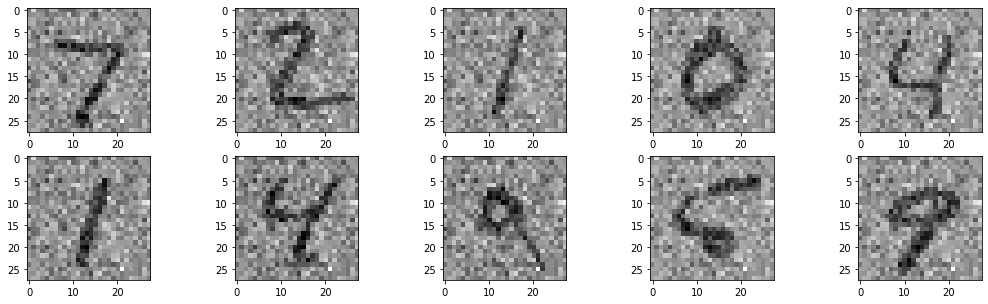

In [57]:
plt.figure(figsize=(18,5))

# display the first 10 images from `x_test_noisy`
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(x_test_noisy[index], cmap=plt.cm.binary)
plt.show()

### Visualize Restored Images

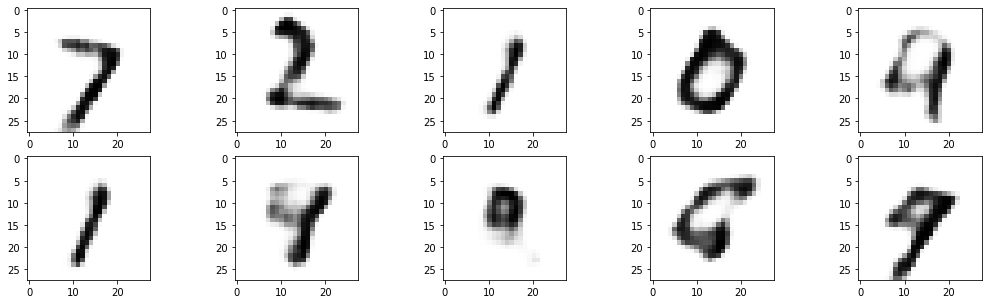

In [58]:
plt.figure(figsize=(18,5))

# display the first 10 images from `restored_imgs`
for index in range(10):
    plt.subplot(2,5, index+1)
    plt.imshow(restored_imgs[index], cmap=plt.cm.binary)
plt.show()

### Conclusion 

Ok - so it worked! We were able to restored damaged images by using an auto-encoder as a restoration model. Apply the same essential idea as in the video from the top of the notebook. 


You might be thinking to yourself "Wait a minute?! We create the problem, then create a solution to the problem? Doesn't this feel a little circular?"

If you were thinking that then, yeah, you'd be right. 

However, in practice what you would be doing is finding a non-deep learning solution for restoring a small amount of images that you can then use as a training set. This might be a manual by-hand solution or by some other means. Then once you have enough copies of damaged and restored pairs, then you can create a training set, train a model, then from that point on the model will do the restoration in an automated fashion. 

-----

# Exercise 2: Introduction to Variational Auto-Encoders



We are going to take the Standard Auto-Encoder framework that we have been playing with and change two things about it. In order to get started on how to understand these changes you are first going to watch the provided video, then we'll break down the important bits in the notebook. 

Although you are highly encouraged to experiment with the code provided, you will not be asked to fill in any missing code in this section. 

**This is an exercise in reading comprehension.** 

There are questions at the end of this section that test your reading comprehension of the technical knowledge that you will be exposed to shortly.


## First some Theory

Watch the following video to get a crash course on the theory of Variational Auto-Encoders. 

The video has a lengthy introduction, so the VAE section actually **starts at about 5:40 and ends at about 9:06**. Afterwards, he goes on to discuss a more sophisticated version of VAE that is outside the scope of today's assignment.

Don't stress out if you don't understand what he is saying. If fact take note of the following: 

- Watch the VAE video 2 - 3 times and absorb as much information as you can
- We will unpack the important bits later in the notebook 


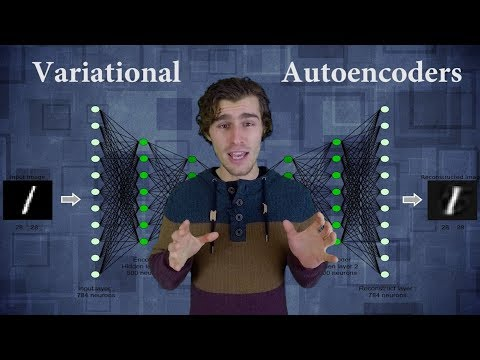

In [59]:
from IPython.display import YouTubeVideo
YouTubeVideo('9zKuYvjFFS8', width=1000, height=500)

![](https://lh3.googleusercontent.com/proxy/9StAnnRiBvF4rNIMEXj2Qc5kGvWHQu7H6wOqxYI9wAPCN3Jy8JUE4awTyslXvFO2Etb2-yY8xgFvAH0zNMx8BUQmQ0Ca2FwgOw)

Having watched the video, you'll see that there's a lot of technical details but we really only care about two things:

- The introduction of the **z_mean** and  **z_log_var** vectors 
- The 2 part loss function with the **Reconstruction loss** and **KL loss** components 

Let's focus on the **z_mean** and  **z_log_var** vectors for now and we'll come back to the loss function later. 

Notice that the Variational Auto-Encoder is our standard Auto-Encoder plus the **z_mean** and  **z_log_var** vectors in the middle. 

Our standard Auto-Encoders also have **latent vectors** - it's simply the output of the last encoding layer!


## Sampling the Normal Distribution in Latent Space

### Latent Space 

First of all **what is Latent Space?**

$$\textbf{Latent Space means a representation of compressed data.}$$

Simple right? 

Hmm..maybe too simple. 

Maybe you want that definition to be unpacked and explained a little more. 

In a **Linear Algebra** context Latent Space is **representing high dimensional data in a low dimensional space.** 


Still want a deeper explanation? 

Then you're in luck! You can [**read this article to get a deeper explaination of Latent Space**](https://towardsdatascience.com/understanding-latent-space-in-machine-learning-de5a7c687d8d#:~:text=The%20latent%20space%20is%20simply,representations%20of%20data%20for%20analysis.) (only if you want to of course). 


### Latent N-dimensional Distribution 

![](https://theaisummer.com/assets/img/posts/Autoencoder/vae.png)


The image above shows the architecture of a Variational Auto-Encoder. Notice how it almost looks exactly like a standard Auto-Encoder? It almost is expect for those latent vectors in the middle. 

The basic idea is that instead of representing the latent vector as simply another vector: as the output vector from the last layer of the encoder model. We are going to **represent the latent vector (call it Z) as having two components: a mean vector component and a variance vector component.** 

![](https://bookdown.org/phamtrongthang123/notebookCEVAE/imgs/2020-04-12-10-49-37.png)

$$\mathbf{Z} = \mathbf{\mu} + \mathbf{\sigma} \bigodot \mathbf{\epsilon}$$

Where $\epsilon$ is sampled from a normal distribution 

$$\epsilon \sim \mathcal{N}(\mu,\,\sigma^{2}) ~=~ \mathcal{N}(0, 1) $$

And $\bigodot$ means matrix product. 

We know that **mean** and **variance** are just numbers, single floating point values, right? So why do we need vectors for these distribution parameters?

Because there is such a thing as an [**N-dimensional Normal distribution**](https://en.wikipedia.org/wiki/Multivariate_normal_distribution). So far in the program, you have only been exposed to univariate (i.e. 1-dimensional) probability distributions (i.e. $P(x)$), which come up a lot in practice so that's why they are so heavily focused on. However, multi-dimensional probability distributions do exists and that is what we will be playing with today. In fact, look at the VAE image and you'll see a 2-dimensional Normal distribution. 

In [61]:
class Sampling(layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample a z vector from the latent N-dimensional Normal distribution
    i.e. Z is the vector encoding a digit.
    """
    def call(self, inputs):
        
        # recall from the video that z_mean and z_log_var are vectors 
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        
        # sample from an N-dimensional normal distribution
        # epsilon is given shape (batch, dim) because we are adding it to z_mean which has shape (batch, dim)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        
        # output of tf.exp() is a vector 
        sigma = tf.exp(0.5 * z_log_var)
        
        # this is our hidden latent vector made up of a mean and variance vector 
        # variance vector is scaled by epsilon, which is sampled from a normal distribtuion 
        # the the video guy said "stocastic" in reference to epsilon, he meant random 
        Z = z_mean + sigma * epsilon
        
        # return hidden latent vector 
        return Z

# Build Variance Auto-Encoder model

We are going to build the Encoder model, followed by the Decoder model. Then bring it all together by using Keras's Model API for building models, just like we did in the guided project. 

## Build Encoder Model

Note that the there is nothing special about the the architecture we are using. You can experiment with different architectures after you've gone through the notebook once. 

In [62]:
# recall from the video that the more dimensions that our latent vector has
# the better the results of our model 
latent_dim = 2

# shape of our input data
# we are creating our input layer using Keras's Input() class
# the only thing that input layers really do is define the dimensionality of the input data for the model
encoder_inputs = Input(shape=(28, 28, 1))

# these are the hidden layers of our encoder model 
# `x` is the output from each layer 
# recall that the data is in the shape of a matrix, hence Conv2D - 2D as in 2-dimensional 
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# now flatten data matrix into data vector 
x = Flatten()(x)
# pass data vector into FCFF layer 
x = Dense(16, activation="relu")(x)
# recall that ordinarly the output of the last encoding layer is the latent vector 
# but here we are creating two output layers for our encoder - one for the mean and one for the log variance 
# returns a 2-dim mean vector
z_mean = Dense(latent_dim, name="z_mean")(x)
# returns a 2-dim log variance vecotr 
z_log_var = Dense(latent_dim, name="z_log_var")(x)
# pass mean and variance vector into Sampling class in order to create the Z vector,  Z = mean + var * epsilon
z = Sampling()([z_mean, z_log_var])

# ok, now let's put it all together 
# this is our encoder model 
# inputs are the original images
# outputs are the Z vectors: mean, log variance, and the complete Z, i.e. vector Z = mean + var * epsilon
encoder = Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 32)   320         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_13[0][0]                  
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_14[0][0]                  
____________________________________________________________________________________________

## Build Decoder Model

Now we can create the decoder model.

There is a new layer here that we should talk about, it's the **Conv2DTranspose** layer. 

This is also known as a **DeConvolutional layer**. It's like the Convolutional layer that we learned about in Sprint 3 Module 2 but it "moves" in the opposite direction. 


Huh? Ok, let me explain. 

### DeConvolution

![](https://miro.medium.com/max/1086/1*AbCrAqPBfkqGRdhKtiZQqA.png)

On the **left hand side** we see what a **Convolution** looks like (this should look familiar). The layer is taking the original image (or feature map) on the left and applying a convolution, the result is a feature map on the right with a smaller dimensionality. 

On the **right hand side** we see what a **DeConvolution** looks like. The layer is taking the feature map (the output of a convolution layer) and attempting to rebuild the original image. 

Recall that a  **Convolution**  slides a weight matrix on an image in order to reduce the dimensionality and to create features which are stored on a matrix (or volume which is a stacking of matrices) call **Feature Maps.** 

The **DeConvolution**  layer starts with **Feature Maps** and tries to create the original image. 

Hence **DeConvolution** is like **Convolution**  just moving in the opposite direction. 

For a deeper explanation [**check out this article**](https://medium.com/@marsxiang/convolutions-transposed-and-deconvolution-6430c358a5b6)

Also don't forget about the [**Keras docs on this layer**](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)

In [75]:
# the input layer to our decoder has the same dimensionality as the latent vector
# because the latent vector is the input to the decoder model
latent_inputs = Input(shape=(latent_dim,))

# these are the hidden layers of our decoder 
# the data at this point is in a vector, the Z latent vector 
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# reshape vector into a matrix
x = Reshape((7, 7, 64))(x)
# increase size of matrix by using DeConvolutional layers
# notice that the number of feature maps (i.e. the first parameter values) are mirror images
# of the number of feature maps from the Conv2D layers in the Encoder
# we saw this mirroring in the auto-encoders we built in the guided project 
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# this is the final layer in out decoder
# therefore this layer outputs the reconstruction of the original image 
decoder_outputs = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

# this is our decoder model 
decoder = Model(inputs=latent_inputs, outputs=decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_8 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Combine Encoder & Decoder into a Variational Auto-Encoder 

Now that we have created the Encoder and Decoder models, we can put it all together to finally create out Variational Auto-Encoder. In order to keep our code tidy, let's define the VAE model as a class. 

**Side Note:** 

You've probably notice how much code needs to written just to run a gridsearch experiment in Sprint 2 and now all the code that one needs to write just to create a deep learning VAE model. Yeah, welcome to Deep Learning folks. DL quickly becomes an engineering problem. Something to consider if you're considering spending a lot of time building DL models. To that point, it's actually a good thing that you're exposed to all of this now so that you can get an honest and proper exposure to what this kind of work is really like.


**property decorator function**

You might have noticed the python decorator above the **metrics()** method in the class below. 

```python
    @property
    def metrics(self):
        """
        Returns all loses in a list
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
```

If you're not familiar with this decorator, [**read this**](https://www.programiz.com/python-programming/property)

In [76]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        """
        This class build a Variational Auto-Encoder. It accepts an Encoder and Decoder model as input. 
        
        Note
        ----
        This VAE class is inheriting Keras's Model API so that it can use the Model class methods 

        """
        # how python 3 handles inheritance 
        super(VAE, self).__init__(**kwargs)
        # set encoder model as class attribute
        self.encoder = encoder
        # set decoder model as class attribute 
        self.decoder = decoder
        # set mean function as class attribute - this calculates the total loss
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        # set mean function as class attribute - this calculates the reconstruction loss
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        # set mean function as class attribute - this calculates the kl loss
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        """
        Returns all loses in a list
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        """
        Training our model via gradient descent and back-propagation 
        """
        
        # we used tf.GradientTape() in Sprint 2 Module 2 to run Gradient Descent from scratch 
        with tf.GradientTape() as tape:
            # pass input data into encoder model 
            # output of encoder model is the hidden state distribution parameters and hidden state vector 
            z_mean, z_log_var, z = self.encoder(data)
            
            # pass hidden state vector into decoder model 
            reconstruction = self.decoder(z)
            
            # calculate the reconstruction loss 
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            
            # calculate the kl loss
            #                (1 + z_sigma   - (z_mean)^2        - e^(z_sigma) ) 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # recall that we used tf.reduce_sum() in Sprint 2 Module 4 assignment 
            # it takes the sum of the vector components 
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # calculate the total loss by adding the two loss components 
            total_loss = reconstruction_loss + kl_loss
            
        # now that we have calculated the loss function, we can perform Gradient Descent
        # we are passing in the loss function and the weights that we want to update via Gradeint Descent 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # log the total loss
        self.total_loss_tracker.update_state(total_loss)
        
        # log the reconsgrution loss 
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        # log the kl loss 
        self.kl_loss_tracker.update_state(kl_loss)
        
        # return all the losses in a dictionary 
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Loss Function 

Ok , let's return to the loss function that the VAE uses. 

From the video, and by reading the code in the VAE class up above, we can see that there are two components to the Loss Function. 

$$\textbf{Total loss = binary crossentropy + KL Divergence}$$

Fortunately, we covered the **CrossEntorpy** loss function in Sprint 2 Module 3, so we're already familiar with that part. But now there's this so called **KL Divergence** loss. So here's the short explanation. 


Let's say that we have a distribution of points but we don't actually know what kind of distribution it is. Is it a normal distribution, a binomial distribution, a Possian distribution, or something else entirely? We don't know. 

So what we can do is form the hypothesis that the distribution of points is a normal distribution. How good is our hypothesis? Well, we can use the KL Divergence to measure how similar the distribution of points is to a normal distribution. The lower the **KL Divergence** score (i.e. the lower the divergence between the two distributions), the better the match. 


So armed with that knowledge let's return to our loss function and break it down. 

$$\textbf{Total loss = binary crossentropy + KL Divergence}$$

**binary crossentropy** is responsible for accounting for the quality of the model's predictions, i.e. (y_pred vs y_true). 


**KL Divergence** is responsible for making sure that the latent probability distribution that our model learns is in fact a normal distribution. And to the extent that the latent probability distribution is not normal, the score will be non-zero. If the learned latent probability distribution is perfectly Normal (or nearly perfectly Normal), then the the score will be zero or near zero. 

### Further Readings

For a deeper explanation of **KL Divergence** using a simple and concrete example [**check out this article.**](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-understanding-kl-divergence-2b382ca2b2a8). 

For a deeper explanation of **KL Divergence** in the context of a VAE [**check out this article**](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/) 

In [77]:
# load in mnist data set
# we don't care about the Y labels since this isn't a supervised classification task 
# this is an unsupervised variational auto-encoder 
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# We don't care about the distinction between train and test sets here
# so combine all data 
mnist_digits = np.concatenate([x_train, x_test], axis=0)

# change shape and normalize pixel values between 0 and 1
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255.

# instantiate a Variational Auto-Encoder model 
vae = VAE(encoder, decoder)

# complie the model 
vae.compile(optimizer=keras.optimizers.Nadam())

# train the model weights 
vae.fit(mnist_digits, epochs=30, batch_size=128, workers=10)
# if you have access to multiple processors, set parameter `workers` to N - 1
# where N is the total number of processors that you have 

Epoch 1/30
547/547 [==============================] - 53s 94ms/step - loss: 255.1474 - reconstruction_loss: 211.3443 - kl_loss: 2.2771
Epoch 2/30
547/547 [==============================] - 51s 94ms/step - loss: 183.3709 - reconstruction_loss: 173.3788 - kl_loss: 4.8449
Epoch 3/30
547/547 [==============================] - 52s 95ms/step - loss: 168.9460 - reconstruction_loss: 162.6515 - kl_loss: 4.8932
Epoch 4/30
547/547 [==============================] - 52s 95ms/step - loss: 163.7446 - reconstruction_loss: 157.4434 - kl_loss: 5.1732
Epoch 5/30
547/547 [==============================] - 52s 95ms/step - loss: 160.7589 - reconstruction_loss: 154.6089 - kl_loss: 5.3896
Epoch 6/30
547/547 [==============================] - 53s 97ms/step - loss: 158.8861 - reconstruction_loss: 152.7172 - kl_loss: 5.5342 
Epoch 7/30
547/547 [==============================] - 56s 102ms/step - loss: 156.9163 - reconstruction_loss: 151.1714 - kl_loss: 5.6356
Epoch 8/30
547/547 [==============================] -

### Visual Results 

Now we will plot our modeling results in order to understand them. 

In [78]:
def generate_digits(digit_size, n, grid_x, grid_y, figure):
    
    """
    This function samples from the 2-Dimensional latent space Normal probability distribution 
    that our model as learned during training.
    """

    ## This code samples images from the 2D Latent Space Normal Probability Distribtuion ##
    # iterate through values in the y-axis
    for i, yi in enumerate(grid_y):
        # iterate through values in the x-axis
        for j, xi in enumerate(grid_x):
            # create a z vector using those (x,y) corrdinates 
            z_sample = np.array([[xi, yi]])
            # pass in that z vector into th decoder model
            # notice that we aren't passing in an image but rather a 2D coordinate, but a 2D coordinate of what?
            # we are sampling from the latent space 2D Normal distribution
            # we pass in a 2D corrdinate, and the decoder passes back whatever image exists at that coordinate
            x_decoded = vae.decoder.predict(z_sample)
            # reshape the image that the decoder returned 
            digit = x_decoded[0].reshape(digit_size, digit_size)
            # store digit image in list for plotting
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
                    
    return figure


def plot_latent_space(vae, n=30, figsize=15):
    """
    This function plots the latent space Normal probability distribution that our model as learned during training. 
    Read through the comments to learn how. 
    
    Parameters
    ----------
    vae: keras object
        Trained Variational Auto-Encoder
        
    n: int
        number of tick marks on the x and y axis 
    """
    
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    # i.e. we are defining the tick marks of the plot
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    # use our trained VAE to generate digit images for us 
    figure = generate_digits(digit_size, n, grid_x, grid_y, figure)
    
    # plot all the digit images that we sampled 
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

### Plot Latent Space 

Take a look at the plot below. How would you describe it?

Our VAE has learned a Latent Space 2-Dimensional Normal probability distribution. 

Depending on your (x,y) coordinate in this space, the distribution has a probability of generating an image for you. Yes, that's right, this model's decoder will generate images for you. All you have to do is provide an (x,y) coordinate. This is true because we have kind of model that is known as a [**Generative Model**](https://towardsdatascience.com/generative-deep-learning-lets-seek-how-ai-extending-not-replacing-creative-process-fded15b0561b). 

Oppose to what? 

### Fundamental difference between Discriminative models and Generative models

**Discriminative models** learn the (hard or soft) boundary between classes

    - Logistic Regression 
    - Random Forest
    - SVM
    - FCFF, LSTM, and CNN neural networks 
    
**Generative models** model the distribution of individual classes

    - Naive Bayes classifier
    - Variational Auto-Encoder 
    - Generative Adversarial Networks 


The plot below shows the distribution of images that our model has learned. Interesting, isn't it?
It's interesting to see how one digit slowly morphs into another digit. 

Make sure to click on the link above to read about some really cool applications of generative models.

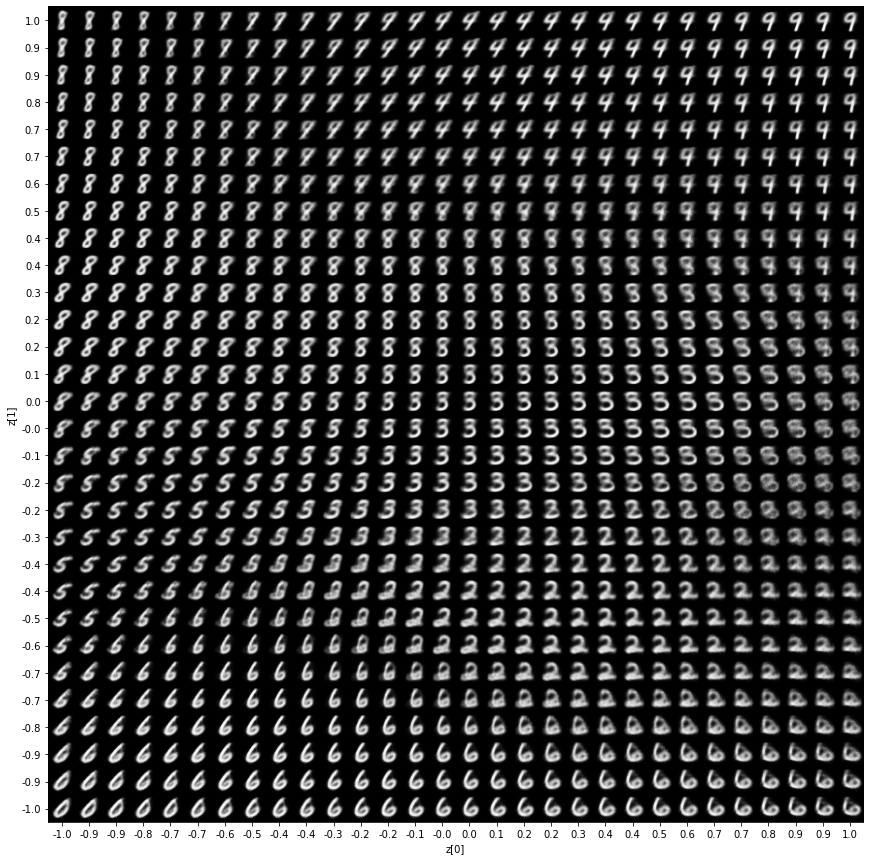

In [79]:
plot_latent_space(vae)

### Plot Label Clusters

The plot below shows us the distribution of digit labels. The VAE passes the original digit image through encoder and plots the **z_mean** vector. We can see that the model thinks that 0's and 1's are spatially dissimilar from 8's and 9's. 

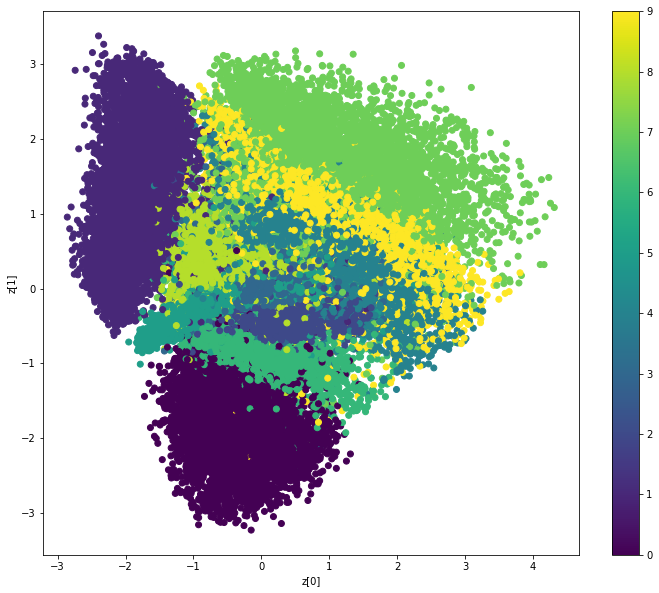

In [80]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

-----
### Time for Questions

In your own words, answer as many of the following questions as you can. 

**Question 1:**

In a couple of simple sentences, **describe the differences between a Standard Auto-Encoder and a Variational Auto-Encoder.**

Think how you would describe the differences to a non-data scientist over a couple of coffee. 


**Answer 1:** The difference between a Standard Auto-Encoder and a Variational Auto-Encoder are in the middle layer of the models (knot of the bowtie). In the Standard Auto-Encoder, there is a single layer in the middle that is the most compressed version of our input data. In the Variational Auto-Encoder, there is a distribution of values in the middle. This provides the VAE with a lot more opportunity to learn and generate better images/data in the decoder/final output layer.

**Question 2:**

Now in technical detail, **describe the differences between a Standard Auto-Encoder and a Variational Auto-Encoder.** 

Think how you would describe the differences in a technical interview. Imagine the interviewer hasn't asked you for in-depth technical details like the equation of the KL Divergence loss function, so you don't want to get lost in the weeds of technical detail. But you do want your explanation to show that you could talk about the technical details if he asked you a follow up question. 


**Answer 2:** A standard autoencoder accepts input, compresses it, and then recreates the original input. A variational autoencoder assumes that the source data has some sort of underlying probability distribution (such as Gaussian) and then attempts to find the parameters of that distribution. The closer that distribution is to a Normal distribution, the lower the KL Divergence Loss of the model will be.

**Question 3:**

How would you describe the technical details **KL Divergence** loss function to a fellow data science student outside the context of a VAE?

**Answer 3:** The KL Divergence Loss function calculates how similar a given distribution is to a Normal distribution.

**Question 4:**

How would you describe the technical details of the entire loss function **Binary CrossEntorpy** and **KL Divergence** loss functions in the context of a VAE in a technical interview?

**Answer 4:** The entire loss function of a VAE model adds the Binary Crossentropy loss and the KL Divergence Loss. The Binary Crossentropy loss measures the quality of the model's predictions and the KL Divergence which measures how similar the distribution in the middle layer is to the Normal distribution. A lower KL Divergence Loss, means that the given distribution is similar to a Normal distribution. A higher KL Divergence Loss means that the given distribution is not very similar to a Normal distribution.